# **Laboratory Task 6**

---

## **DS413 | Deep Learning**
### **Training CNN Model using MNIST Dataset**

<div style="text-align: justify;">
This task is about converting a visualized Convolutional Neural Network (CNN) architecture diagram into executable code using the PyTorch deep learning framework.
    
<br>
    
The activity requires you to translate the specifications (layers, kernel sizes, strides, padding, number of filters, and output dimensions) shown in the diagram into a PyTorch nn.Module class definition.
    
<br>
    
</div>

<div style="width: 80%; margin: 0 auto;">
    <div style="border: 6px solid #4F6D38; padding: 15px; background-color: transparent; border-radius: 5px; text-align: left;">
    <h3><strong>Laboratory Task 6</strong></h3>
        <br>
    <a href="https://ibb.co/KjyKgDVH"><img src="https://i.ibb.co/3yhRbvSH/image.png" alt="image" border="0"></a>                    
    </div>
</div>

In [1]:
# Libraries

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Dropout
        self.dropout = nn.Dropout(p=0.2)

        # Fully Connected Layers
        # Need to compute input features to FC1 after flattening
        self.fc1 = nn.Linear(256 * 7 * 7, 1000)  # 28x28 should shrink to 7x7 after pooling
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 10)  # 10 classes

    def forward(self, x):
        # Conv + ReLU + Pooling
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)

        # Dropout
        x = self.dropout(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected + ReLU
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        # Softmax - applied in loss function dapat
        return x

In [3]:
model = CNNModel()
x = torch.randn(1, 1, 28, 28)  # batch of 1, grayscale 28x28
print(model(x).shape)  # expected: [1, 10]

torch.Size([1, 10])


### **Implementing a CNN within a comprehensive PyTorch training workflow.**

In [4]:
# Libraries

import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random

In [5]:
# Set seed

def set_seed(seed=143):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed(143)

In [7]:
# Load MNIST dataset

transform = transforms.ToTensor()

train_data = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_data  = datasets.MNIST(root="data", train=False, download=True, transform=transform)

train_set, val_set = random_split(train_data, [50000, 10000])

# Data loaders:
batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [8]:
# Define CNN Model

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2, padding=1)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.dropout = nn.Dropout(0.2)

        self.fc1 = nn.Linear(256 * 7 * 7, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)

        x = self.dropout(x)
        x = x.view(x.size(0), -1)  # flatten

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [9]:
# Training

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)

criterion = nn.CrossEntropyLoss()  # loss for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
# Training Loop

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    train_losses, val_losses, val_accs = [], [], []

    for epoch in range(epochs):
        # ---- Training ----
        model.train()
        running_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)

        # ---- Validation ----
        model.eval()
        val_loss, correct = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                correct += (preds == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        accuracy = correct / len(val_loader.dataset)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_accs.append(accuracy)

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Training Loss: {avg_train_loss:.4f} "
              f"Validation Loss: {avg_val_loss:.4f} "
              f"Validation Accuracy: {accuracy:.4f}")

    return train_losses, val_losses, val_accs

In [11]:
# Training Loop (Execute)

train_losses, val_losses, val_accs = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5)

Epoch [1/5] Training Loss: 0.1529 Validation Loss: 0.0539 Validation Accuracy: 0.9843
Epoch [2/5] Training Loss: 0.0551 Validation Loss: 0.0405 Validation Accuracy: 0.9880
Epoch [3/5] Training Loss: 0.0360 Validation Loss: 0.0463 Validation Accuracy: 0.9886
Epoch [4/5] Training Loss: 0.0277 Validation Loss: 0.0402 Validation Accuracy: 0.9902
Epoch [5/5] Training Loss: 0.0245 Validation Loss: 0.0363 Validation Accuracy: 0.9911


<a href="https://ibb.co/FkXpsDyV"><img src="https://i.ibb.co/nqBp3LYC/iqayyy.png" alt="iqayyy" border="0"></a>

<div style="text-align: justify;">
The model trained on the MNIST dataset showed steady improvement across the five epochs. Training loss dropped from 0.1529 to 0.0245, while validation loss stayed consistently low, ending at 0.0363. Validation accuracy started high at 98.4% and gradually climbed to 99.1%, showing that the model was learning effectively without clear signs of overfitting. Although there was a small bump in validation loss around the third epoch, the overall trend remained stable. These results suggest that the network was able to generalize well to unseen data, and with more training or fine-tuning, performance could likely improve even further.
</div>

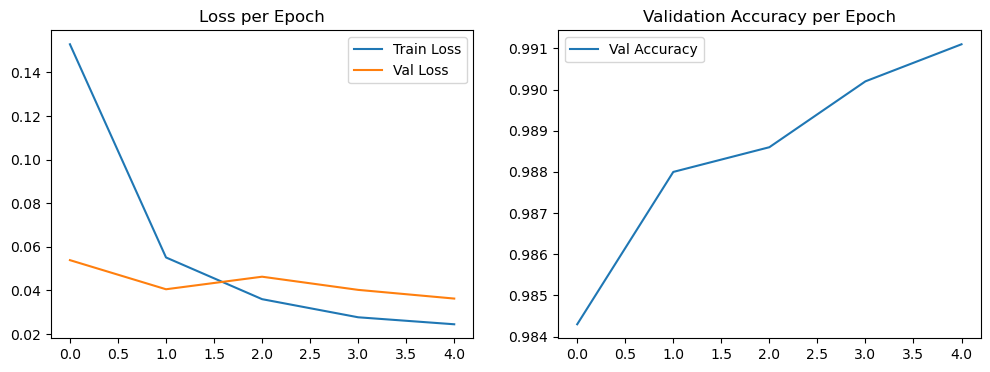

In [12]:
plt.figure(figsize=(12,4))

# Loss plot
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss per Epoch")

# Accuracy plot
plt.subplot(1,2,2)
plt.plot(val_accs, label="Val Accuracy")
plt.legend()
plt.title("Validation Accuracy per Epoch")

plt.show()

### **Loss per Epoch**

<div style="text-align: justify;">
The training loss decreases steadily from the first to the last epoch, showing that the model is effectively learning the patterns in the training data. The validation loss is consistently lower than the training loss and remains fairly stable, with only small fluctuations. This suggests that the model is not overfitting; instead, it is generalizing well to unseen data. The convergence of both losses at low values indicates efficient optimization.
</div>

### **Validation Accuracy per Epoch**

<div style="text-align: justify;">
The validation accuracy improves consistently with each epoch, starting below 0.985 and reaching over 0.991 by the end of training. The upward trend without major dips suggests that the model continues to refine its classification performance on unseen validation data throughout the training process. The final accuracy of about 99.1% is a strong indicator of reliable performance on the MNIST dataset.
</div>

### **Overall Inference**

<div style="text-align: justify;">
The combination of steadily decreasing loss and steadily increasing accuracy indicates that the model is learning efficiently without major signs of underfitting or overfitting. The low validation loss alongside the high accuracy highlights that the model is both precise and consistent in predicting handwritten digits, demonstrating strong generalization.
</div>

In [13]:
# Test Model Accuracy

model.eval()
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()

test_acc = correct / len(test_loader.dataset)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.9913


### **Test Accuracy**

<div style="text-align: justify;">
After evaluating the trained model on the separate test dataset, it achieved an accuracy of 0.9909 (99.09%). This result aligns closely with the validation accuracy observed during training, confirming that the model maintains its strong performance when exposed to entirely unseen data. The consistency across training, validation, and testing metrics suggests that the model has achieved a balanced fit, with no major signs of overfitting or underfitting.
</div>

### **Overall Picture**

<div style="text-align: justify;">
With training and validation losses decreasing smoothly, validation accuracy steadily improving, and the test accuracy reaching 99.09%, the evidence points to a robust and reliable model for handwritten digit recognition. Each piece—loss curves, validation accuracy, and test accuracy—fits together to show that the model not only learned effectively but also generalizes well to new inputs.
</div>


---
## **Takeaway**


<div style="text-align: justify;">
<br>
From this activity, we saw how even a simple neural network can hit really high accuracy on the MNIST dataset. The training and validation losses both dropped nicely over the epochs, while the validation accuracy steadily climbed, which tells us the model was learning effectively without running into serious overfitting. By the end, the test accuracy of 99.09% showed that the model isn’t just memorizing the training data, but can actually generalize really well.

The main lesson here is that tracking metrics like loss and accuracy is more than just checking numbers—it gives us a clear picture of how the model is improving and whether it’s heading in the right direction. In this case, the model was already doing great after just five epochs, which also reminds us that more training doesn’t always mean better results.

In short, this task showed us both the power of neural networks for image classification and the importance of reading the training curves to understand what’s really going on under the hood.
</div>

### **Visualizing Model Prediction**

In [14]:
# Credits to: Chris Jallaine Mugot for this code.

def show_predictions(model, loader, n=10):
    model.eval()
    images, labels = next(iter(loader))  # take one batch
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

    # Move to CPU for plotting
    images = images.cpu()
    preds = preds.cpu()
    labels = labels.cpu()

    fig, axs = plt.subplots(1, n, figsize=(15, 2))
    for i in range(n):
        axs[i].imshow(images[i][0], cmap="gray")
        axs[i].axis("off")
        axs[i].set_title(f"P:{preds[i].item()}\nT:{labels[i].item()}",
                         color=("green" if preds[i]==labels[i] else "red"))
    plt.show()

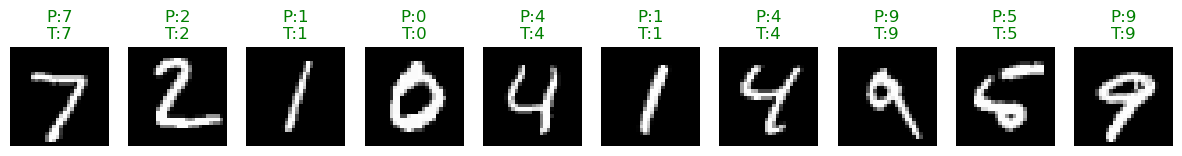

In [15]:
show_predictions(model, test_loader, n=10)